In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixtureAlgorithms as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/SMC-WFR/utils.py'>

In [2]:
w = 1/2
sigma = 1
weights = np.array([w, 1-w])

In [3]:
m = np.arange(1, 11)
d = 1

In [4]:
N = 500
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
Nrep = 50
Niter = 200
gamma = 0.3

In [5]:
LSI = np.sqrt(sigma)*(1 + (np.exp(m**2)-1)/2)
LSI

array([1.85914091e+00, 2.77990750e+01, 4.05204196e+03, 4.44305576e+06,
       3.60024497e+10, 2.15561577e+15, 9.53673286e+20, 3.11757454e+27,
       7.53048657e+34, 1.34405857e+43])

In [6]:
lseq_linear = np.arange(1, Niter+1)/Niter
alpha = 0.01
lseq_exponential = 1-np.exp(-alpha*np.arange(1, Niter+1))
lseq_optimal = 1-1/(2+np.arange(1, Niter+1))

delta_linear = (gamma+np.exp(-gamma)-1)/gamma
delta_exponential = (alpha*(np.exp(-gamma)-1)-np.exp(-alpha*gamma)+1)/(1-alpha)
t = np.linspace(0, gamma, 100)
delta_optimal = 1-np.exp(-gamma) - np.exp(-gamma)*(t[1]-t[0])*np.sum(np.exp(t)/(2+t))

In [7]:
times_ula = np.zeros((m.size, Nrep))
times_tula_linear = np.zeros((m.size, Nrep))
times_tula_exponential = np.zeros((m.size, Nrep))
times_tula_optimal = np.zeros((m.size, Nrep))

mmd_ula = np.zeros((Niter, m.size, Nrep))
mmd_tula_linear = np.zeros((Niter, m.size, Nrep))
mmd_tula_exponential = np.zeros((Niter, m.size, Nrep))
mmd_tula_optimal = np.zeros((Niter, m.size, Nrep))

times_wfr = np.zeros((m.size, Nrep))
times_twfr_linear = np.zeros((m.size, Nrep))
times_twfr_exponential = np.zeros((m.size, Nrep))
times_twfr_optimal = np.zeros((m.size, Nrep))

mmd_wfr = np.zeros((Niter, m.size, Nrep))
mmd_twfr_linear = np.zeros((Niter, m.size, Nrep))
mmd_twfr_exponential = np.zeros((Niter, m.size, Nrep))
mmd_twfr_optimal = np.zeros((Niter, m.size, Nrep))

In [9]:
for i in range(m.size):
    ms = np.array([np.zeros(d), m[i]*np.ones(d)])
    Sigmas = np.array([sigma*np.eye(d), sigma*np.eye(d)])
    component = np.random.choice(2, p = weights, size = N)
    true_sample = np.zeros((N, d))
    for n in range(N):
        true_sample[n, :] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)
    for j in range(Nrep):
        # ULA
        start = time.time()
        ula_chain = algo.ParallelULA(gamma, Niter, ms, Sigmas, weights, X0)
        end = time.time()
        times_ula[i, j] = end-start
        for k in range(Niter):
            mmd_ula[k, i, j] = u.mmd_rbf(true_sample, ula_chain[k, :, :].T)
        # Tempered ULA linear
        start = time.time()
        tempered_ula_chain_linear = algo.TemperedULA(gamma, Niter, ms, Sigmas, weights, X0, lseq_linear)
        end = time.time()
        times_tula_linear[i, j] = end-start
        for k in range(Niter):
            mmd_tula_linear[k, i, j] = u.mmd_rbf(true_sample, tempered_ula_chain_linear[k, :, :].T)
        # Tempered ULA exponential
        start = time.time()
        tempered_ula_chain_exponential = algo.TemperedULA(gamma, Niter, ms, Sigmas, weights, X0, lseq_exponential)
        end = time.time()
        times_tula_exponential[i, j] = end-start
        for k in range(Niter):
            mmd_tula_exponential[k, i, j] = u.mmd_rbf(true_sample, tempered_ula_chain_exponential[k, :, :].T)
        # Tempered ULA optimal
        start = time.time()
        tempered_ula_chain_optimal = algo.TemperedULA(gamma, Niter, ms, Sigmas, weights, X0, lseq_optimal)
        end = time.time()
        times_tula_optimal[i, j] = end-start
        for k in range(Niter):
            mmd_tula_optimal[k, i, j] = u.mmd_rbf(true_sample, tempered_ula_chain_optimal[k, :, :].T)

        # WFR
        start = time.time()
        wfr_x, wfr_w = algo.WFR(gamma, Niter, ms, Sigmas, weights, X0)
        end = time.time()
        times_wfr[i, j] = end-start
        for k in range(Niter):
            mmd_wfr[k, i, j] = u.mmd_rbf(true_sample, wfr_x[k, :, :].T, w = wfr_w[k, :])
        # Tempered WFR linear
        start = time.time()
        tempered_wfr_linear_x, tempered_wfr_linear_w = algo.TemperedWFR(gamma, Niter, ms, Sigmas, weights, X0, lseq_linear, delta_linear)
        end = time.time()
        times_twfr_linear[i, j] = end-start
        for k in range(Niter):
            mmd_twfr_linear[k, i, j] = u.mmd_rbf(true_sample, tempered_wfr_linear_x[k, :, :].T, w = tempered_wfr_linear_w[k, :])
        # Tempered WFR exponential
        start = time.time()
        tempered_wfr_exponential_x, tempered_wfr_exponential_w = algo.TemperedWFR(gamma, Niter, ms, Sigmas, weights, X0, lseq_exponential, delta_exponential)
        end = time.time()
        times_twfr_exponential[i, j] = end-start
        for k in range(Niter):
            mmd_twfr_exponential[k, i, j] = u.mmd_rbf(true_sample, tempered_wfr_exponential_x[k, :, :].T, w = tempered_wfr_exponential_w[k, :])
        # Tempered WFR optimal
        start = time.time()
        tempered_wfr_optimal_x, tempered_wfr_optimal_w = algo.TemperedWFR(gamma, Niter, ms, Sigmas, weights, X0, lseq_optimal, delta_optimal)
        end = time.time()
        times_twfr_optimal[i, j] = end-start
        for k in range(Niter):
            mmd_twfr_optimal[k, i, j] = u.mmd_rbf(true_sample, tempered_wfr_optimal_x[k, :, :].T, w = tempered_wfr_optimal_w[k, :])

In [10]:
eps = 0.01

In [11]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Text(0.5, 0, '$m$')

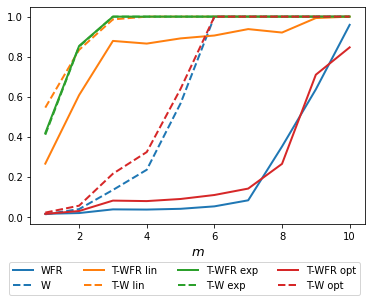

In [12]:
plt.plot(m, (Niter - np.mean(np.sum(mmd_wfr<eps, axis = 0), axis = 1))/Niter, label = 'WFR', lw = 2, color = colors[0]);
plt.plot(m, (Niter - np.mean(np.sum(mmd_ula<eps, axis = 0), axis = 1))/Niter, label = 'W', lw = 2, linestyle = 'dashed');
plt.plot(m, (Niter - np.mean(np.sum(mmd_twfr_linear<eps, axis = 0), axis = 1))/Niter, label = 'T-WFR lin', lw = 2, color = colors[1]);
plt.plot(m, (Niter - np.mean(np.sum(mmd_tula_linear<eps, axis = 0), axis = 1))/Niter, label = 'T-W lin', lw = 2, linestyle = 'dashed');
plt.plot(m, (Niter - np.mean(np.sum(mmd_twfr_exponential<eps, axis = 0), axis = 1))/Niter, label = 'T-WFR exp', lw = 2, color = colors[2]);
plt.plot(m, (Niter - np.mean(np.sum(mmd_tula_exponential<eps, axis = 0), axis = 1))/Niter, label = 'T-W exp', lw = 2, linestyle = 'dashed');
plt.plot(m, (Niter - np.mean(np.sum(mmd_twfr_optimal<eps, axis = 0), axis = 1))/Niter, label = 'T-WFR opt', lw = 2, color = colors[3]);
plt.plot(m, (Niter - np.mean(np.sum(mmd_tula_optimal<eps, axis = 0), axis = 1))/Niter, label = 'T-W opt', lw = 2, linestyle = 'dashed');
plt.legend(fontsize = 10, ncol = 4, bbox_to_anchor=(1.0, -0.15))
plt.xlabel('$m$', fontsize = 13)
# plt.savefig("gaussian_mix_1dm.pdf", bbox_inches='tight')

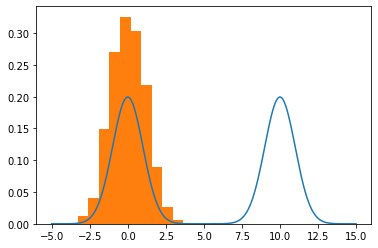

In [13]:
x = np.linspace(-5, 15, 1000)
z = 0
for j in range(weights.size):
    z += weights[j]*norm.pdf(x, ms[j,:], Sigmas[j,:,:])
plt.plot(x, z.T)
plt.hist(tempered_wfr_exponential_x[-1, 0, :], density = True, weights = tempered_wfr_exponential_w[-1, :]);

In [15]:
np.mean(times_wfr), np.mean(times_twfr_linear), np.mean(times_twfr_exponential), np.mean(times_twfr_optimal)

(0.505929166316986, 0.5066459589004516, 0.5050102715492248, 0.5056481313705444)